## Surface-Mediated Anharmonic Down Conversion Study
Study of pulse observables as a function of the "scaling parameter". The scaling parameter is a constant which scales the average of surface anharmonic decay curves.

In [1]:
# Imported required modules
import matplotlib.pyplot as plt
%pylab inline
import matplotlib
%matplotlib inline
import pandas as pd
from pylab import *
import matplotlib.patches as mpatches
import numpy
import ROOT
from ROOT import TH1D, TFile
import glob

# This line is needed since RDataFrame.AsNumpy references np.object which has been deprecated since NumPy v1.20.00
np.object = object

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.24/06


In [2]:
# obtain template. Contains "CH3", "CH2", and "Total". Our studies only use CH3.
import pickle
import joblib

filename_default_template='/home/spaudel/projects/rrg-mdiamond/spaudel/decay/Templates/Templates_8192.pkl'
Templates=joblib.load(filename_default_template) 

In [3]:
# time bins for TESSim traces
phononBins = np.arange(-9830400.0, -9830400.0 + 24576 * 800, 800) * 1e-3 # ns -> us

In [4]:
# Use glob.glob to read in jobs with similar names and file paths. The unique elements of the file name are used as keys
# in the dictionary that contains the filenames 'DMCfiles'.

temp = "/home/spaudel/projects/rrg-mdiamond/spaudel/decay/output/2023-07-31 VERIFICATION/all_readback_????_51230731_000000.root"
filenames = sorted(glob.glob(temp))

# Identify the unique parameter value from the file path names.

values = ['' for i in range(len(filenames))]

for i in range(len(filenames)):
    for j in range(len(filenames[i])):
        if filenames[i][j] != temp[j]:
            values[i] += filenames[i][j]

values = [float(i) for i in values]
print(f'Scaling Parameter: {values}')

# dictionary containing file names
DMCfiles = {}
for i in range(len(filenames)):
    DMCfiles.update({values[i]: filenames[i]})
    
# Prints DMCfiles
# pprint.pprint(DMCfiles)
    
# dictionary to contain data from files
d = {}
for file in DMCfiles:
    d.update({file: {}})


Scaling Parameter: [0.1, 0.01, 0.001, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0]


In [5]:
def getCrystalsim(DMCfile, branches):
    #### Retrieve CrystalSim Data, Used to get PhononE values for this study ####
    branches_dic = {}
    for br in branches:
        branches_dic.update({br: []})

    data = ROOT.RDataFrame('G4SimDir/g4dmcEvent', DMCfile, branches).AsNumpy(branches)
    
    for event in range(len(data)):
        for br in branches:
            branches_dic[br].append(data[br][event])
            
    for br in branches:
        branches_dic[br] = np.array(branches_dic[br])
    
    return tuple(branches_dic.values())

In [6]:
def getTES(file):
    #### Retrieving the TES traces for each channel ####
    branches = ['Trace', 'ChanName']
    tes1, tes2 = [], []
    
    data = ROOT.RDataFrame('G4SimDir/g4dmcTES', file, branches).Filter("DataType==0").AsNumpy(branches)
    
    for i in range(len(data['ChanName'])):
        if ''.join(array(data['ChanName'][i])[:3]) == 'Ch1':
            tes1.append(data['Trace'][i])
        if ''.join(array(data['ChanName'][i])[:3]) == 'Ch2':
            tes2.append(data['Trace'][i])

    tes1, tes2 = array(tes1), array(tes2)
    
    #### TES traces are turned rightside up ####
    tes1 = array([max(i) - i for i in tes1])
    tes2 = array([max(i) - i for i in tes2])
    
    return tes1, tes2

In [7]:
def f(tes1):
    p1_1, p2_1 = numpy.polyfit(phononBins[12388:12503], log(tes1[12388:12503]), 1) # exponential fit for 80 < t < 172 us
    p1_2, p2_2 = numpy.polyfit(phononBins[12913:13288], log(tes1[12913:13288]), 1) # exponential fit for 500 < t < 800 us
    
    f1 = abs(1/p1_1) # fall-time of first exponential
    f2 = abs(1/p1_2) # fall-time of second exponential
    
    return f1, f2, p2_1, p2_2

In [8]:
# obtaining needed data for analysis
for file in DMCfiles:

    d[file]['PhononE'] = getCrystalsim(DMCfiles[file], ['PhononE'])[0]
    d[file]['PhononE1'] = array([i[0] for i in d[file]['PhononE']])
    d[file]['PhononE2'] = array([i[1] for i in d[file]['PhononE']])
    d[file]['PhononE'] = array([sum(i) for i in d[file]['PhononE']])
    d[file]['tes1'], d[file]['tes2'] = getTES(DMCfiles[file])
        
    d[file]['f1_1'], d[file]['f2_1'], d[file]['a1_1'], d[file]['a2_1'] = f(d[file]['tes1'][0])
    d[file]['f1_2'], d[file]['f2_2'], d[file]['a1_2'], d[file]['a2_2'] = f(d[file]['tes2'][0])

(-100.0, 1000.0)

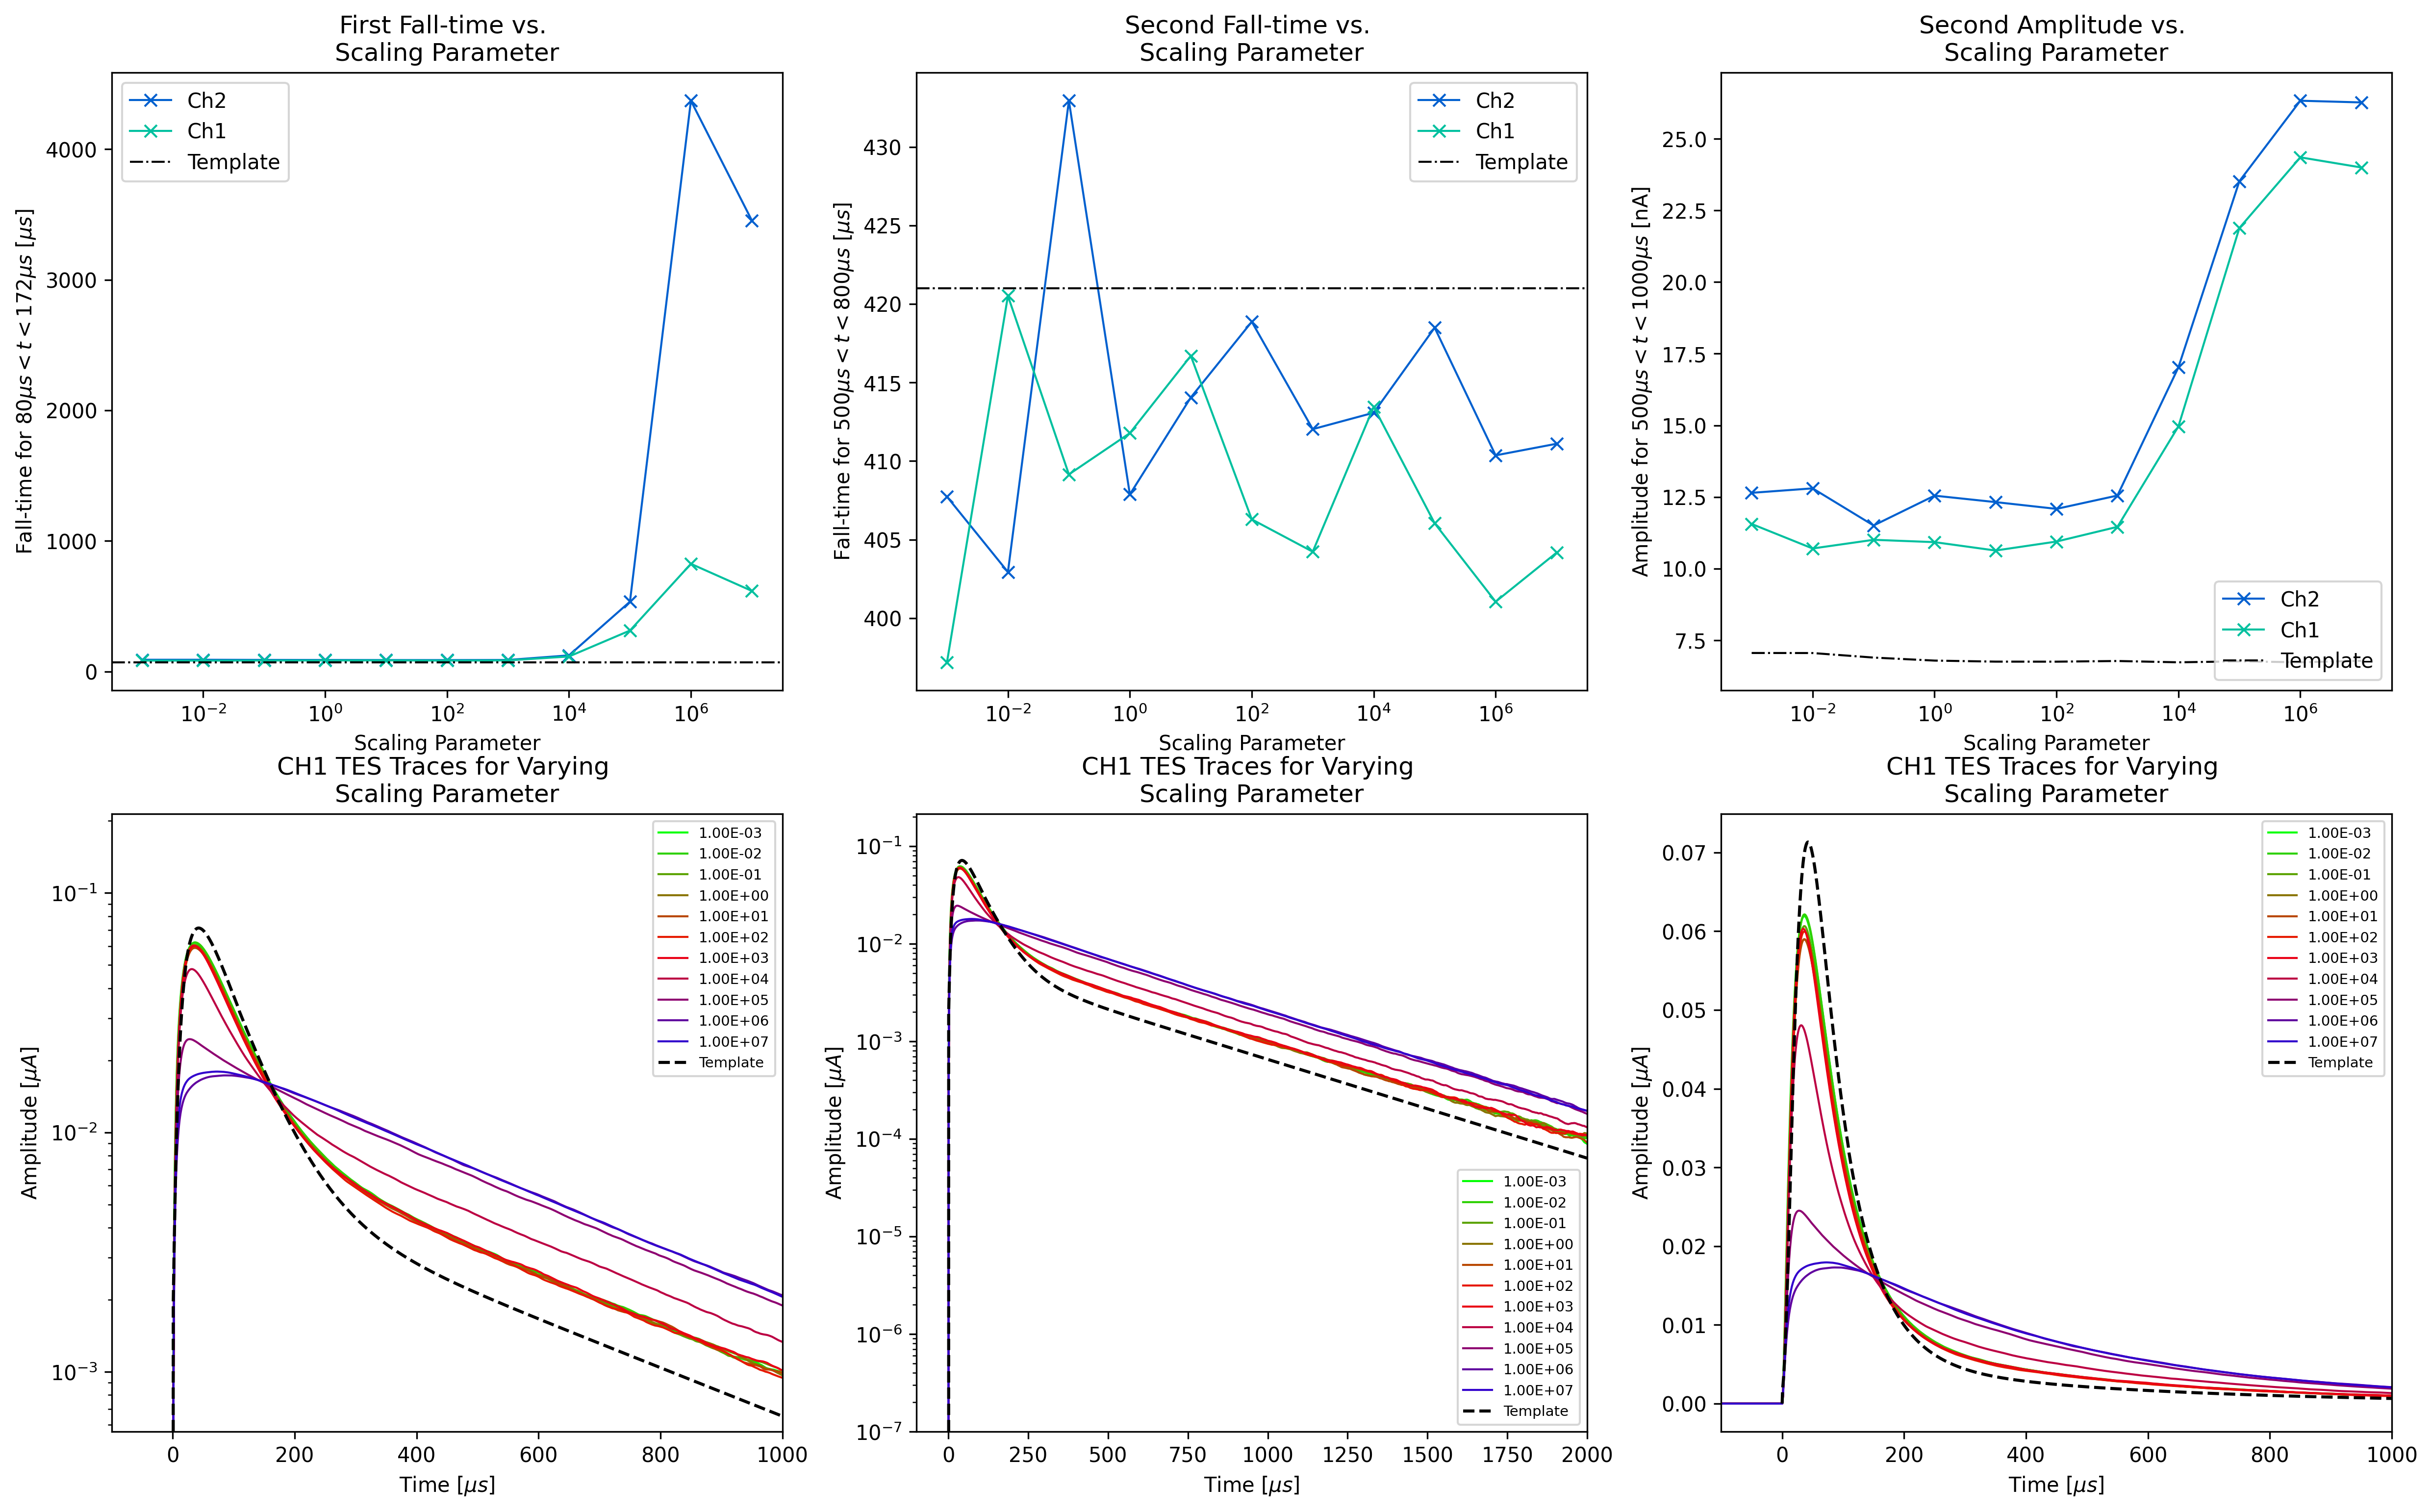

In [18]:
# study as observables change as a function of scaling parameter
x = list(DMCfiles.keys())
x.sort()

# two colors to be used for plotting
c1 = (0.0, 0.7529411764705882, 0.6235294117647059, 1.0)
c2 = (0.0, 0.3764705882352941, 0.8117647058823529, 1.0)

# scale factor for template as a function of CH1 phonon energy
tempPeak1 = np.array([(25 * (-1200 + sqrt(15) * sqrt(96000 + 73 * d[i]['PhononE1'][0])))/7884 for i in x])

# First Fall-Time vs. Scaling Parameter ----------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(2, 3, figsize=(20, 12), dpi=300)

y1 = array([d[i]['f1_1'] for i in x])
y2 = array([d[i]['f1_2'] for i in x])

ax[0,0].plot(x, y2, 'x', ls = '-', lw = 1, color = c2, label = 'Ch2')
ax[0,0].plot(x, y1, 'x', ls = '-', lw = 1, color = c1, label = 'Ch1')
ax[0,0].axhline(70.6, 0, 1, lw = 1, color = 'black', ls = '-.', label = 'Template')
ax[0,0].set_xlabel(r'Scaling Parameter')
ax[0,0].set_ylabel(r'Fall-time for $80 \mu s < t < 172 \mu s$ [$\mu s$]')
ax[0,0].set_title('First Fall-time vs. \nScaling Parameter')
ax[0,0].legend()
ax[0,0].set_xscale('log')
ax[0,0].ticklabel_format(axis="y", useOffset=False, style='plain')
ax[0,0].autoscale()

# Second Fall-Time vs. Scaling Parameter ---------------------------------------------------------------------------------------------------

y1 = array([d[i]['f2_1'] for i in x])
y2 = array([d[i]['f2_2'] for i in x])

ax[0,1].plot(x, y2, 'x', ls = '-', lw = 1, color = c2, label = 'Ch2')
ax[0,1].plot(x, y1, 'x', ls = '-', lw = 1, color = c1, label = 'Ch1')
ax[0,1].axhline(421, 0, 1, lw = 1, color = 'black', ls = '-.', label = 'Template')
ax[0,1].set_xlabel(r'Scaling Parameter')
ax[0,1].set_ylabel(r'Fall-time for $500 \mu s < t < 800 \mu s$ [$\mu s$]')
ax[0,1].set_title('Second Fall-time vs. \nScaling Parameter')
ax[0,1].legend()
ax[0,1].set_xscale('log')
ax[0,1].ticklabel_format(axis="y", useOffset=False, style='plain')

# Second Amplitude vs. Scaling Parameter ---------------------------------------------------------------------------------------------------

y1 = array([np.exp(d[i]['a2_1']) for i in x]) * 1e3
y2 = array([np.exp(d[i]['a2_2']) for i in x]) * 1e3
bins = phononBins[12288: 12288 + 4096]

amp = []
for i in range(len(tempPeak1)):
    amp.append(numpy.polyfit(bins[625:1250], log((Templates['CH3'][4095:-1] * tempPeak1[i])[625:1250]), 1)[1])

ax[0,2].plot(x, y2, 'x', ls = '-', lw = 1, color = c2, label = 'Ch2')
ax[0,2].plot(x, y1, 'x', ls = '-', lw = 1, color = c1, label = 'Ch1')
ax[0,2].plot(x, np.exp(amp) * 1e3, lw = 1, color = 'black', ls = '-.', label = 'Template')
ax[0,2].set_xlabel(r'Scaling Parameter')
ax[0,2].set_ylabel(r'Amplitude for $500 \mu s < t < 1000 \mu s$ [nA]')
ax[0,2].set_title('Second Amplitude vs. \nScaling Parameter')
ax[0,2].legend(loc='lower right')
ax[0,2].set_xscale('log')
ax[0,2].ticklabel_format(axis="y", useOffset=False, style='plain')

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

### visual check of pulses with varying Scaling Parameter and comparison to template scaled to the average appropriate scaling for all jobs ###
# Zoomed in traces on log scale -----------------------------------------------------------
cmap = plt.get_cmap('brg')
c = [cmap(i) for i in np.linspace(1, 0.1, len(x))]

for i in x:
    ax[1,0].plot(phononBins, d[i]['tes1'][0], color = c[x.index(i)], label = '%.2E' % i, lw = 1)
    
ax[1,0].plot(phononBins[12288: 12288+4096], Templates['CH3'][4095:-1] * mean(tempPeak1), ls = '--', color = 'black', label = 'Template')

ax[1,0].set_xlabel(r'Time [$\mu s$]')
ax[1,0].set_ylabel(r'Amplitude [$\mu A$]')
ax[1,0].set_title('CH1 TES Traces for Varying \nScaling Parameter')
ax[1,0].legend(fontsize = 7)
ax[1,0].set_xlim(-100, 1000)
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(pow(10, -3.25), None)

# Zoomed out traces on log scale -----------------------------------------------------------
cmap = plt.get_cmap('brg')
c = [cmap(i) for i in np.linspace(1, 0.1, len(x))]

for i in x:
    ax[1,1].plot(phononBins, d[i]['tes1'][0], color = c[x.index(i)], label = '%.2E' % i, lw = 1)
    
ax[1,1].plot(phononBins[12288: 12288+4096], Templates['CH3'][4095:-1] * mean(tempPeak1), 
         ls = '--', color = 'black', label = 'Template')

ax[1,1].set_xlabel(r'Time [$\mu s$]')
ax[1,1].set_ylabel(r'Amplitude [$\mu A$]')
ax[1,1].set_title('CH1 TES Traces for Varying \nScaling Parameter')
ax[1,1].legend(fontsize = 7)
ax[1,1].set_xlim(-100, 2000)
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(pow(10, -7), None)

# Zoomed in pulses on linear scale ---------------------------------------------------------
cmap = plt.get_cmap('brg')
c = [cmap(i) for i in np.linspace(1, 0.1, len(x))]

for i in x:
    ax[1,2].plot(phononBins, d[i]['tes1'][0], color = c[x.index(i)], label = '%.2E' % i, lw = 1)
    
ax[1,2].plot(phononBins[12288: 12288+4096], Templates['CH3'][4095:-1] * mean(tempPeak1), 
         ls = '--', color = 'black', label = 'Template')

ax[1,2].set_xlabel(r'Time [$\mu s$]')
ax[1,2].set_ylabel(r'Amplitude [$\mu A$]')
ax[1,2].set_title('CH1 TES Traces for Varying \nScaling Parameter')
ax[1,2].legend(fontsize = 7)
ax[1,2].set_xlim(-100, 1000)